# Mercado inmobiliario - Santiago de Chile

Un proyecto de práctica implementado por **Julio Torres, Victor Núñez, Sanber Viscaya**

Fecha: Abril 17 - 2024

## Libraries

In [31]:
from  warnings import filterwarnings
filterwarnings('ignore')

In [32]:
import pandas as pd, numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import panel as pn
pn.extension('tabulator')
import hvplot.pandas
import holoviews as hv

from unidecode import unidecode
import pickle
import re

## 1) Load Data

In [33]:
data = pd.read_csv('dataset.csv')
df = data.copy()

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10429 entries, 0 to 10428
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Dirección               10429 non-null  object 
 1   Precio_CLP              10429 non-null  float64
 2   Precio_UF               10429 non-null  float64
 3   Gastos_comunes          8347 non-null   float64
 4   Dormitorios             10429 non-null  int64  
 5   Baños                   10429 non-null  int64  
 6   Estacionamiento         10429 non-null  object 
 7   Superficie_total        10429 non-null  float64
 8   Superficie_útil         10429 non-null  float64
 9   Descripción             10429 non-null  object 
 10  Fecha_de_publicación    10429 non-null  object 
 11  Agente_inmobiliario     10429 non-null  object 
 12  ID_de_publicación       10429 non-null  int64  
 13  Decada_de_construccion  3202 non-null   float64
 14  Cocina                  10429 non-null

In [35]:
df.isna().sum()

Dirección                    0
Precio_CLP                   0
Precio_UF                    0
Gastos_comunes            2082
Dormitorios                  0
Baños                        0
Estacionamiento              0
Superficie_total             0
Superficie_útil              0
Descripción                  0
Fecha_de_publicación         0
Agente_inmobiliario          0
ID_de_publicación            0
Decada_de_construccion    7227
Cocina                       0
Terraza                      0
Bodega                       0
Piscina                      0
Comuna                       0
Dirección_2                  0
Año                          0
Mes                          0
Día                          0
Zona                         0
Precio_x_m2tot               0
Precio_x_m2util              0
dtype: int64

### 1.1 Processing

In [36]:
df.Terraza.value_counts()

Terraza
Si    10333
No       96
Name: count, dtype: int64

- **Terraza**

In [37]:
df =  df.drop(['Terraza'], axis = 1)

- **Dirección**

In [38]:
with open("expresiones_eliminar.txt", "r") as file:
    expresiones_eliminar = file.read().split(',')

# Eliminar espacios adicionales alrededor de cada expresión
expresiones_eliminar = [expresion.strip() for expresion in expresiones_eliminar]

for expresion in expresiones_eliminar:
    df['dir'] = df['Dirección_2'].str.replace(expresion, '', regex=True)

df = df.drop(['Dirección_2'], axis = 1)

df['dir'] = df['dir'].str.split(',').str[1]
df['dir'] = df['dir'].apply(lambda x: x.split('/')[0])

#Vamos a eliminar cualquier número en la dir:
df['dir'] = df['dir'].str.replace(r'\d', '', regex=True).apply(lambda x: x.strip())

#Eliminamos filas con valores que no aportan.
df = df.drop(df['dir'][df['dir'].str.contains(r'(nuevo|vende|Inversionist|bonito|oportunidad|cerca|oferta|semi|metro$|departamento|comodo|buen|hermo|Depto|fnb|venta|!!!|jumbo|cinemark|sodimac)', flags = re.IGNORECASE)].index)

#llevamos todo a mayusculas para evitar tener diferentes categorías al codificar:
df['dir'] = df['dir'].apply(lambda x: x.upper())

#Eliminamos las tildes
df['dir'] = df['dir'].apply(lambda x: unidecode(x))

- **Gastos Comunes**

In [39]:
#Eliminamos valores atípicos en los Gatos comunes (Máx el sueldo mínimo en Chile y no menores que 15mil pesos):
df = df.drop(df['Gastos_comunes'][lambda x: x>500E3].index)
df = df.drop(df['Gastos_comunes'][lambda x: x<15E3].index)

comunas =  df['Comuna'].unique().tolist()

# Llenamos los valores nulos con el promedio por comuna:
for comuna in comunas:
    promedio = round(df['Gastos_comunes'][df.Comuna == 'Santiago'].mean())
    df['Gastos_comunes'][(df.Comuna == comuna) & (df.Gastos_comunes.isna())] = promedio

- **Año/Decada de construcción**

In [40]:
df = df.rename(columns={'Decada_de_construccion':'Año_de_construcción'})

# Para un pirmer test vamos a considerar el promedio para rellenar los valores faltantes
df['Año_de_construcción'] = df['Año_de_construcción'].fillna(round(df['Año_de_construcción'].mean()))

# Fechas de construcción ilogicas:
df = df.drop(df['Año_de_construcción'][lambda x: x>2024].index) 

- **Otras medidas**

In [41]:
#Removemos valores atípicos
df = df.drop(df['Superficie_total'][lambda x: x<=0].index)
df = df.drop(df['Superficie_útil'][lambda x: x<=0].index)
df = df.drop(df[df['Superficie_útil']>df['Superficie_total']].index)

# Eliminamos estas filas, son precios incorrectos (menos de 10M de pesos Chilenos).
# Tambien consideramos precios hasta un maximo de 1000M
df = df.drop(df['Precio_CLP'][lambda x: x<10E6].index)
df = df.drop(df['Precio_CLP'][lambda x: x>1000E6].index) 


# Para un pirmer test vamos a considerar el promedio para rellenar los valores faltantes
df['Año_de_construcción'] = df['Año_de_construcción'].fillna(round(df['Año_de_construcción'].mean()))

# Fechas de construcción:
df = df.drop(df['Año_de_construcción'][lambda x: x>2024].index) 
df = df.drop(df['Año_de_construcción'][lambda x: x<1940].index) 

# Precio en UF de momento no es necesaria
df = df.drop(['Precio_UF'], axis = 1)

In [42]:
df =  df.drop(['Fecha_de_publicación', 'Descripción', 'Descripción', 'Zona',
               'Año', 'Día', 'Mes', 'ID_de_publicación', 'Dirección', 'Precio_x_m2tot','Precio_x_m2util'
              ], axis = 1)

### 1.2 Graphs

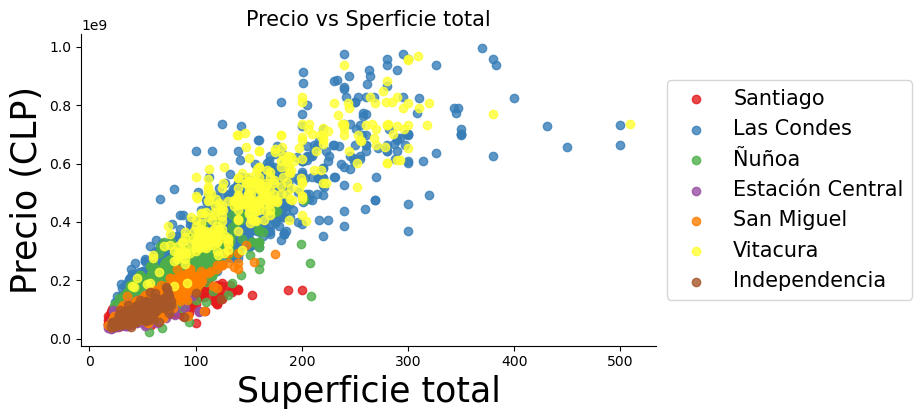

In [43]:
sns.lmplot(x='Superficie_total', y='Precio_CLP', data=df, 
           fit_reg=False, 
           hue='Comuna', 
           legend=False,
           palette='Set1',
           height= 4,
           aspect = 2
          )
ax1 = plt.gca()
ax1.set_title('Precio vs Sperficie total', size=15)
ax1.set_xlabel('Superficie total', size = 25)
ax1.set_ylabel('Precio (CLP)', size = 25)
# Shrink current axis by 20%
box = ax1.get_position()
ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5),prop={'size': 15})
plt.show()

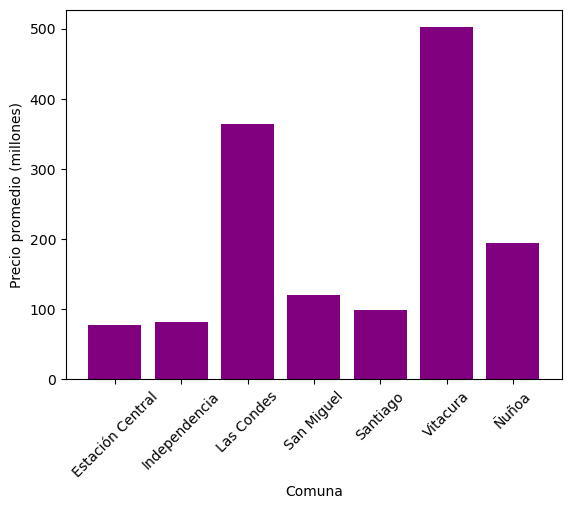

In [44]:
precio_prom = df.groupby('Comuna')['Precio_CLP'].mean().to_frame().reset_index()
precio_prom['Precio_CLP'] = precio_prom['Precio_CLP']/1E6

plt.figure()
plt.bar(precio_prom['Comuna'], precio_prom['Precio_CLP'], color='purple')
plt.ylabel('Precio promedio (millones)')
plt.xlabel('Comuna')
plt.xticks(rotation=45)
plt.show()

## 2) Machine Learning

### 2.2 Encoding Categoricals

In [45]:
from sklearn.preprocessing import LabelEncoder

In [46]:
# Save LabelEncoders rules.
label_encoders = {}

#Encoding object
for col in df.select_dtypes(object).columns:
    enc = LabelEncoder()
    df[col] = enc.fit_transform(df[col])
    label_encoders[col] = enc

# Encoding bool
for col in df.select_dtypes(bool).columns:
    df[col] = df[col].astype(int)

# Save LabelEncoders
with open('label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)

### 2.3 Data transform

In [47]:
from scipy.stats import skew
import numpy as np

In [48]:
df['Año_de_construcción'] = df['Año_de_construcción']/max(df['Año_de_construcción'])

In [49]:
skew_df = pd.DataFrame(df.columns, columns = ['Features'])
skew_df['Skew'] = skew_df['Features'].apply(lambda x: df[x].skew())
skew_df['Abs Skew']= skew_df['Skew'].apply(abs)
skew_df['Skewned'] = skew_df['Abs Skew'].apply(lambda x: True if x>0.5 else False)
skew_df['Min_value'] = skew_df['Features'].apply(lambda x: min(df[x]))
skew_df

,Features,Skew,Abs Skew,Skewned,Min_value
0,Precio_CLP,2.183535,2.183535,True,2.394521e+07
1,Gastos_comunes,2.632905,2.632905,True,1.500000e+04
2,Dormitorios,0.605504,0.605504,True,1.000000e+00
3,Baños,1.212537,1.212537,True,1.000000e+00
4,Estacionamiento,0.360390,0.360390,False,0.000000e+00
5,Superficie_total,2.626121,2.626121,True,1.700000e+01
6,Superficie_útil,2.376236,2.376236,True,1.500000e+01
7,Agente_inmobiliario,-0.115808,0.115808,False,0.000000e+00
8,Año_de_construcción,-4.919845,4.919845,True,9.584980e-01
9,Cocina,-0.855544,0.855544,True,0.000000e+00


In [50]:
for col in skew_df[skew_df['Skewned'] == True]['Features'].values:
    df[col] = np.log1p(df[col])

In [51]:
#to save
def data_transform(df):
    cols_to_transform = [ 'Gastos_comunes', 'Dormitorios', 'Baños', 'Superficie_total', 'Superficie_útil',
                         'Año_de_construcción','Cocina','Bodega','Piscina','dir']
    for col in cols_to_transform:
        df[col] = np.log1p(df[col])
    return df

### 2.4 Scaling

In [52]:
from sklearn.preprocessing import StandardScaler

In [53]:
scaler = StandardScaler()
scaler.fit(df.iloc[:,1:])

df.iloc[:,1:] = scaler.transform(df.iloc[:,1:])

In [54]:
#save scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

### 2.6 Split Data

In [55]:
from sklearn.model_selection import train_test_split

In [56]:
target = df['Precio_CLP']
X = df.drop(['Precio_CLP'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, target, test_size= 0.1, random_state=2024)

### 2.7 Model Selection

In [57]:
from pycaret.regression import setup, compare_models

In [58]:
#setup(data = pd.concat([X_train, y_train], axis = 1), target = 'Precio_CLP')
#compare_models()

### 2.8 Ensemble Learning (Random Forest Regressor)

In [59]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

#### Hyper-parameters search

In [60]:
#RandomForestRegressor
rfr_params = {'n_estimators':[100,200],
             'max_depth': [2,3,4,5],
             'max_features': [3,4],
             'random_state':[0]
              }

rfr = GridSearchCV(RandomForestRegressor(), rfr_params, scoring='neg_mean_squared_error', n_jobs=-1, cv=6)
rfr.fit(X_train, y_train)
rfr_params = rfr.best_params_

print('Best Params rfr model :',rfr.best_params_)
print('Best Score rfr model:', rfr.best_score_)
print('\n')

Best Params rfr model : {'max_depth': 5, 'max_features': 4, 'n_estimators': 200, 'random_state': 0}
Best Score rfr model: -0.04478064340519985




#### Training and metrics

In [61]:
# RandomForestRegressor
rfr = RandomForestRegressor(**rfr_params)
rfr.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, max_features=4, n_estimators=200,
                      random_state=0)

In [62]:
y_pred_rfr = rfr.predict(X_test)

rfr_mse = mean_squared_error(y_true= y_test, y_pred= y_pred_rfr)
print('Test MSE of rfr model:', rfr_mse )

Test MSE of rfr model: 0.04586142509061857


#### Plot feature importance

**feature_importances** calcula la importancia de las características a partir del modelo entrenado. La importancia de cada característica es un valor numérico que indica cuánto contribuyó esa característica a las predicciones realizadas por el modelo.

**MDI**: "Disminución Media de la Impureza. Es una medida de la importancia de las características en los modelos de ensemble basados en árboles. La idea detrás de la MDI es cuantificar cómo una característica particular contribuye a reducir la impureza (o aumentar la homogeneidad) en los nodos de los árboles de decisión durante el proceso de construcción del modelo.

La importancia por permutación es una técnica utilizada para evaluar la importancia de las características en un modelo de aprendizaje automático. Se basa en la premisa de que si la importancia de una característica es alta, entonces la permutación aleatoria de los valores de esa característica debería tener un impacto significativo en el rendimiento del modelo.

In [63]:
from sklearn.inspection import permutation_importance

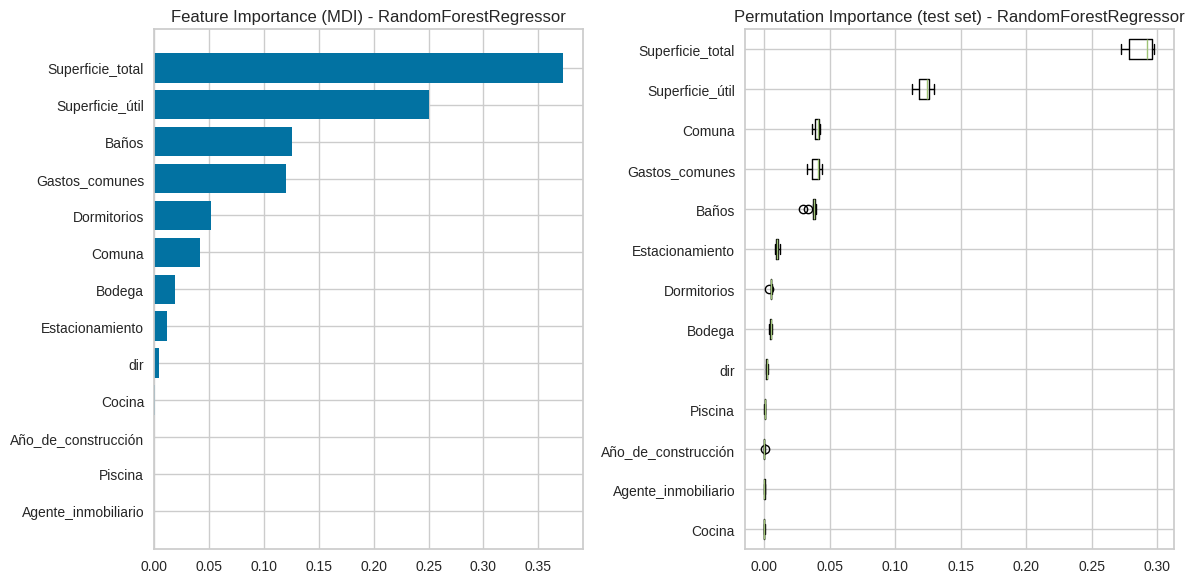

In [64]:
feature_importance = rfr.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(df.iloc[:,1:].columns)[sorted_idx])
plt.title("Feature Importance (MDI) - RandomForestRegressor")

result = permutation_importance(
    rfr, X_test, y_test, n_repeats=10, random_state=0, n_jobs=-1
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(df.iloc[:,1:].columns)[sorted_idx],
)
plt.title("Permutation Importance (test set) - RandomForestRegressor")
fig.tight_layout()

plt.savefig('Feature Importance-rfr.png', dpi=400)

plt.show()

### 2.9 Ensemble Learning (GradientBoostingRegressor)

In [65]:
from sklearn.ensemble import GradientBoostingRegressor

#### Hyper-parameters search

In [66]:
#GradientBoostingRegressor

gbr_params = {'learning_rate':[0.1, 0.5, 1.0],
             'max_depth': [2,3,4,5],
             'n_estimators':[100,200],
             'random_state':[0]
              }

gbr = GridSearchCV(GradientBoostingRegressor(), gbr_params, scoring='neg_mean_squared_error', n_jobs=-1, cv=6)
gbr.fit(X_train, y_train)
gbr_params = gbr.best_params_

print('Best Params gbr model:',gbr.best_params_)
print('Best Score gbr model :', gbr.best_score_)
print('\n')

Best Params gbr model: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'random_state': 0}
Best Score gbr model : -0.024309399088276906




#### Training and metrics

In [67]:
#GradientBoostingRegressor
gbr = GradientBoostingRegressor(**gbr_params)
gbr.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=5, n_estimators=200, random_state=0)

In [71]:
y_pred_gbr = gbr.predict(X_test)

gbr_mse = mean_squared_error(y_true= y_test, y_pred= y_pred_gbr)
print('Test MSE of gbr model:', gbr_mse )

Test MSE of gbr model: 0.025613215049164195


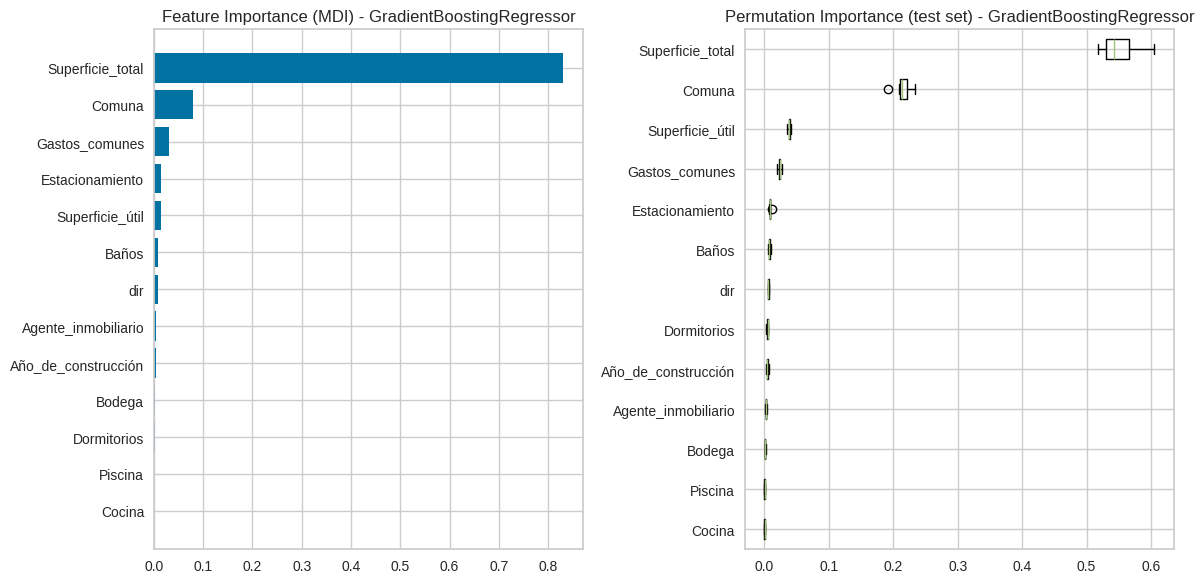

In [73]:
feature_importance = gbr.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(df.iloc[:,1:].columns)[sorted_idx])
plt.title("Feature Importance (MDI) - GradientBoostingRegressor")

result = permutation_importance(
    gbr, X_test, y_test, n_repeats=10, random_state=0, n_jobs=-1
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(df.iloc[:,1:].columns)[sorted_idx],
)
plt.title("Permutation Importance (test set) - GradientBoostingRegressor")
fig.tight_layout()
plt.savefig('Feature Importance-gbr.png', dpi=400)
plt.show()

### 2.10 Results

In [74]:
preds = pd.DataFrame({'Precio pubicado (M)': (np.exp(y_test)-1)/1E6,
                      'rfr_model': (np.exp(rfr.predict(X_test))-1)/1E6,
                      'gbr_model': (np.exp(gbr.predict(X_test))-1)/1E6
                       }
                      ).reset_index()


button_1 = pn.widgets.RadioButtonGroup(name = 'Model',
                                           options=['rfr_model', 'gbr_model'],
                                          button_type = 'success')

@pn.depends(model = button_1)

def model_1(model):
    scatter_plot = preds.hvplot(kind = 'scatter', x = 'Precio pubicado (M)', y = model,
                         xlabel = 'Precio real (Millones)',
                         ylabel = 'Predicción (Millones)',
                         title  = 'Predicción vs Precios reales',
                         xlim=(0,500), ylim=[0,750]
                         )
    linea_ajuste  = hv.Curve(([preds.iloc[:,1].min(), preds.iloc[:,1].max()],
                              [preds.iloc[:,1].min(), preds.iloc[:,1].max()]))\
                              .opts(color = 'black')
    
    return (scatter_plot * linea_ajuste).opts(show_legend=True)
    
dashboard = pn.Column(button_1, model_1)

dashboard.servable()

Column
    [0] RadioButtonGroup(button_type='success', name='Model', options=['rfr_model', ...], value='rfr_model')
    [1] ParamFunction(function, _pane=HoloViews, defer_load=False)

In [76]:
preds

,index,Precio pubicado (M),rfr_model,gbr_model
0,1871,81.045316,89.331761,81.704910
1,7168,189.793395,170.954808,193.359493
2,2311,110.147952,132.001519,125.475205
3,5384,652.046406,698.708466,783.453590
4,2752,114.200218,116.500029,129.554100
...,...,...,...,...
919,6239,276.290850,207.190123,222.557808
920,750,92.096950,105.628880,94.986049
921,6611,117.884096,133.972982,146.262478
922,4697,165.774510,133.675942,204.371469


### 2.11 Create Model File

In [77]:
import pickle

In [78]:
# Guardar modelo
pkl_filename = "gbr_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(gbr, file)

### 2.12 Code snipe for testing

In [79]:
#source : https://chilepropiedades.cl/ver-publicacion/venta/nunoa/departamento/exequiel-fernandez/27074378
#Precio: $189.707.658
new_data = {'Gastos_comunes': {0: 130000.0},
 'Dormitorios': {0: 2},
 'Baños': {0: 2},
 'Estacionamiento': {0: 'Si'},
 'Superficie_total': {0: 65.0},
 'Superficie_útil': {0: 58.0},
 'Agente_inmobiliario': {0: 'No especifica'},
 'Año_de_construcción': {0: 2015.0},
 'Cocina': {0: 'Cocina Integrada'},
 'Bodega': {0: 'Si'},
 'Piscina': {0: 'Si'},
 'Comuna': {0: 'Ñuñoa'},
 'dir': {0: 'EXEQUIEL FERNANDEZ'}}
new_data = pd.DataFrame(new_data)

In [80]:
# Cargar modelo
pkl_filename = "gbr_model.pkl"
with open(pkl_filename, 'rb') as f_in:
    gbr_model = pickle.load(f_in)

# Cargar LabelEncoders
with open('label_encoders.pkl', 'rb') as f:
    label_encoders = pickle.load(f)

# Cargar scaler
with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

In [81]:
# Aplicar la codificación a las columnas de tipo objeto en los nuevos datos
for col, enc in label_encoders.items():
    new_data[col] = enc.transform(new_data[col])

# Aplicar la conversión a enteros para las columnas de tipo bool
for col in new_data.select_dtypes(bool).columns:
    new_data[col] = new_data[col].astype(int)

# Aplicar transformada
new_data = data_transform(new_data)

# Aplicar scaler
new_data.iloc[:,:] = scaler.transform(new_data.iloc[:,:])

In [82]:
#Predicción
prediction = (np.exp(gbr_model.predict(new_data))-1)/1E6

In [89]:
print('Precio según el modelo (en millones):',prediction[0])

Precio según el modelo (en millones): 200.75170330187214
